# README
Run this notebook to create the dataset for mosaic training.

In [1]:
from torch.utils.data import Dataset as BaseDataset

import utils
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

import copy
import random
import time
from functools import wraps

import torch
from pathlib import Path
import numpy as np
from numpy.linalg import LinAlgError
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from einops import rearrange, repeat

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm
import logging

from skimage import morphology

np.random.seed(42)
random.seed(42)

In [2]:
def get_patch_label(file):
    # [a: Tumor (TUM), b: Stroma (STR), c: Lymphocytic infiltrate (LYM), d: Necrosis (NEC)]
    if isinstance(file, Path):
        file = str(file)
    fname = file[:-4]
    label_str = fname.split(']')[0].split('[')[-1]
    label = [int(label_str[0]),int(label_str[1]),int(label_str[2]),int(label_str[3])]
    return label

In [3]:
def timeit(fn):
    """decorator for timing functions"""
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        logging.info(f"@timefn: {fn.__name__} took {t2 - t1: .5f} s")
        return result
    return measure_time

def visualize(save=None, **images):
    """PLot images in one row."""
    fontsize=14
    def axarr_show(axarr, image, name):
        if isinstance(image, torch.Tensor):
            if image.ndim == 3: image = image.permute(1, 2, 0)
            if image.is_cuda: image = image.detach().cpu().numpy()
        if name == 'mask': 
            palette = [0]*15
            palette[0:3] = [255, 0, 0]
            palette[3:6] = [0,255,0]
            palette[6:9] = [0,0,255]
            palette[9:12] = [153, 0, 255]
            palette[12:15] = [255, 255, 255]
            image = Image.fromarray(np.uint8(image), mode='P')
            image.putpalette(palette)
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
        elif 'background' in name:
            palette = [255, 255, 255, 0, 0, 0]
            image = Image.fromarray(np.uint8(image), mode='P')
            image.putpalette(palette)
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
        else:
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
    n = len(images)
    fig, axarr = plt.subplots(nrows=1, ncols=n, figsize=(8, 8))
    if n == 1:
        name, image = list(images.items())[0]
        axarr_show(axarr, image, name)
        axarr.set_yticks([])
        axarr.set_xticks([])
    else:
        for i, (name, image) in enumerate(images.items()):
            axarr_show(axarr[i], image, name)
            
        for ax in axarr.ravel():
            ax.set_yticks([])
            ax.set_xticks([])
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()

In [4]:
train_image_dir = Path('data/BCSS-WSSS/training/')
train_image_list = sorted(list(train_image_dir.glob('*.png')))
len(train_image_list)

23422

In [5]:
only_tum_num = 0
only_str_num = 0
only_lym_num = 0
only_nec_num = 0
single_type_num = 0

only_tum_list = []
only_str_list = []
only_lym_list = []
only_nec_list = []

for train_image in train_image_list:
    big_label = get_patch_label(train_image)
    if np.sum(big_label) == 1:
        single_type_num += 1
        if big_label[0] == 1:
            only_tum_num += 1
            only_tum_list.append(train_image)
        elif big_label[1] == 1:
            only_str_num += 1
            only_str_list.append(train_image)
        elif big_label[2] == 1:
            only_lym_num += 1
            only_lym_list.append(train_image)
        elif big_label[3] == 1:
            only_nec_num += 1
            only_nec_list.append(train_image)
            
assert single_type_num == only_tum_num + only_str_num + only_lym_num + only_nec_num
assert len(only_tum_list) == only_tum_num
assert len(only_str_list) == only_str_num
assert len(only_lym_list) == only_lym_num
assert len(only_nec_list) == only_nec_num


In [6]:
print(only_tum_num, only_str_num, only_lym_num, only_nec_num)
print(single_type_num)

4738 2903 679 1058
9378


----

In [7]:
class CropAndConcatDataset(BaseDataset):    
    def __init__(self, args, patch_num, patch_size, size=None):
       
        self.args = args
        self.train_dir = args.train_dir
        self.train_images = list(Path(self.train_dir).glob('*.png'))
        self.tum, self.str, self.lym, self.nec = only_tum_list, only_str_list, only_lym_list, only_nec_list
        self.single_type_images = self.tum + self.str + self.lym + self.nec

        self.patch_num = patch_num
        self.patch_size = patch_size

        self.total_len = len(self.single_type_images) if size is None else size

        self.crop_fn = albu.Compose([
            albu.PadIfNeeded(min_height=self.patch_size, min_width=self.patch_size),
            albu.RandomCrop(width=self.patch_size, height=self.patch_size)
        ])
        
        self.transform = albu.Compose([
            albu.Flip(),
            albu.RandomRotate90(),
        ])
    
    def __getitem__(self, i):
        np.random.seed(2022 + 2022 * i)
        random.seed(2022 + 2022 * i)
        
        H = W = self.patch_num * self.patch_size
        
        while True:
            try:
                (image_1, mask_1), (image_2, mask_2), (image_3, mask_3), (image_4, mask_4) = [self.create_one_image() for _ in range(4)] # [H, W, C]
                image, mask = self.create_mosaic(H, W, image_1, mask_1, image_2, mask_2, image_3, mask_3, image_4, mask_4)
                break            
            except AssertionError as e:
                print(e)

        
        return image, mask

    def create_one_image(self):      
        H = W = self.patch_num * self.patch_size
        image = np.zeros((H, W, 3), dtype=np.uint8)
        mask = np.zeros((H, W), dtype=np.uint8)

        for i in range(self.patch_num):
            for j in range(self.patch_num):

                tile_name = np.random.choice(self.single_type_images)
                label = get_patch_label(tile_name)
                assert sum(label) == 1
                tile = np.asarray(Image.open(tile_name))
                label = label.index(1)
                tile_mask = np.full((tile.shape[0], tile.shape[1]), label)

                sample = self.crop_fn(image=tile, mask=tile_mask)
                tile = sample['image']
                tile_mask = sample['mask']
                
                image[i*self.patch_size: (i+1)*self.patch_size, j*self.patch_size: (j+1)*self.patch_size] = tile
                mask[i*self.patch_size: (i+1)*self.patch_size, j*self.patch_size: (j+1)*self.patch_size] = tile_mask
        
        return image, mask
    
    def create_mosaic(self, H, W, image_1, mask_1, image_2, mask_2, image_3, mask_3, image_4, mask_4):
        def get_transforms(height, width, p=0.5):
            _transform = [
                albu.Flip(p=p),
                albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=p),
                albu.RandomCrop(height, width),
            ]
            return albu.Compose(_transform)
        
        image = np.zeros((H, W, 3), dtype=np.uint8)
        mask = np.zeros((H, W), dtype=np.uint8)

        h, w = int(H * (random.random()*0.6+0.2)), int(W * (random.random()*0.6+0.2))
        h += h % 2
        w += w % 2

        transform_1 = get_transforms(height=h, width=w, p=0.8)
        sample = transform_1(image=image_1, mask=mask_1)
        image_1, mask_1 = sample['image'], sample['mask']

        transform_2 = get_transforms(height=h, width=W-w, p=0.8)
        sample = transform_2(image=image_2, mask=mask_2)
        image_2, mask_2 = sample['image'], sample['mask']

        transform_3 = get_transforms(height=H-h, width=w, p=0.8)
        sample = transform_3(image=image_3, mask=mask_3)
        image_3, mask_3 = sample['image'], sample['mask']

        transform_4 = get_transforms(height=H-h, width=W-w, p=0.8)
        sample = transform_4(image=image_4, mask=mask_4)
        image_4, mask_4 = sample['image'], sample['mask']
        
        image[:h, :w, :] = image_1
        image[:h, w:W, :] = image_2
        image[h:H, :w, :] = image_3
        image[h:H, w:W, :] = image_4
    
        mask[:h, :w] = mask_1
        mask[:h, w:W] = mask_2
        mask[h:H, :w] = mask_3
        mask[h:H, w:W] = mask_4
        
        return image, mask

    def __len__(self):
        return self.total_len

In [8]:
from argparse import Namespace
from torch.utils.data import DataLoader
args = Namespace()
args.train_dir = "./data/BCSS-WSSS/training"

# set to 2 and 112 for better performance
patch_num = 2
patch_size = 112
dataset = CropAndConcatDataset(args, patch_num=patch_num, patch_size=patch_size, size=20000)
dataloader = DataLoader(dataset, batch_size=16, num_workers=8)

len(dataset)

20000

0
(224, 224, 3) (224, 224)


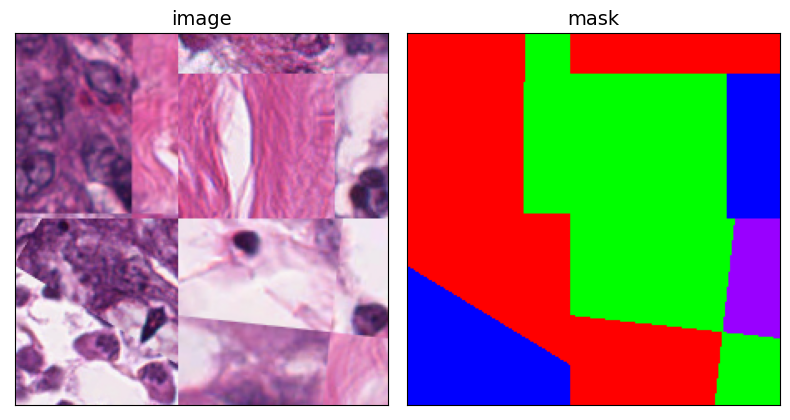

In [9]:
for i, (image, mask) in enumerate(dataset):
    print(i)
    print(image.shape, mask.shape)
    visualize(image=image, mask=mask)

    break


In [10]:
mosaic_data = Path(f"./data/BCSS-WSSS/mosaic_{patch_num}_{patch_size}")
(mosaic_data / 'img').mkdir(parents=True, exist_ok=True)
(mosaic_data / 'mask').mkdir(parents=True, exist_ok=True)
def func(indexes):
    for i in indexes:
        image, mask = dataset[i]
        image = Image.fromarray(image)
        palette = [0]*15
        palette[0:3] = [255, 0, 0]
        palette[3:6] = [0,255,0]
        palette[6:9] = [0,0,255]
        palette[9:12] = [153, 0, 255]
        palette[12:15] = [255, 255, 255]
        mask = Image.fromarray(np.uint8(mask), mode='P')
        mask.putpalette(palette)
        image.save(mosaic_data / 'img' / f'{patch_num}_{patch_size}_{i}.png')
        mask.save(mosaic_data / 'mask' / f'{patch_num}_{patch_size}_{i}.png')
def print_error(value):
    print("error: ", value)

In [11]:
from multiprocessing import Process
process_list = []
num_processors = 8
for i in range(num_processors): 
    p = Process(target=func,args=(range(i, len(dataset), num_processors),)) 
    p.start()
    process_list.append(p)

for i in process_list:
    p.join()